In [2]:
import numpy as np
import ltspice
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

import pandas as pd
from __future__ import division
import re

/var/folders/kf/ylc1lssd1yn8zng1yqdkp1300000gn/T/ipykernel_36165/309332590.py:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


## Functions to load and plot .raw files

In [12]:
def plot_dynamic(arrs, plots_metadata, x_scale='linear', y_scale='linear', is_data_in_dB=False, mark_cutoff=False, num_plots=None):
    plot_number = 1  # Initialize plot number before the loop
    for data, meta in zip(arrs, plots_metadata):
        n_vars = int(meta[b'no. variables']) - 1
        if num_plots is not None:
            n_vars = min(n_vars, num_plots)  # Limit the number of plots if num_plots is set

        x_var_name = meta['varnames'][0]
        x_data = data[x_var_name]  # Assume x-data is positive and linear

        fig, axes = plt.subplots(n_vars, 1, figsize=(10, 5 * n_vars))
        if n_vars == 1:
            axes = [axes]  # Make axes iterable if only one plot

        for i in range(1, n_vars + 1):
            ax = axes[i-1 if n_vars > 1 else 0]
            y_var_name = meta['varnames'][i]
            y_data = data[y_var_name]
            
            label = y_var_name
            y_data_plot = y_data  # Assume the data is already correctly formatted for plotting
            
            ax.plot(x_data, y_data_plot, label=label)
            ax.ticklabel_format(style='plain', axis='both', useOffset=False)
            #ax.set_xlabel(f'{x_var_name} ({meta["varunits"][0]})')
            ax.set_xlabel(f'frequency (Hz)')
            ax.set_ylabel(f'{y_var_name} ({meta["varunits"][i]})')
            ax.set_xscale(x_scale)
            ax.set_yscale(y_scale)
            #ax.set_title(f'{y_var_name} vs. {x_var_name} ({plot_number})')
            ax.legend()
            ax.grid(True)

            if mark_cutoff and is_data_in_dB:
                max_gain = np.max(y_data_plot)
                db3_drop = max_gain - 3
                max_gain_index = np.argmax(y_data_plot)

                lower_indices = np.where(y_data_plot[:max_gain_index] <= db3_drop)[0]
                upper_indices = np.where(y_data_plot[max_gain_index:] <= db3_drop)[0] + max_gain_index
                
                if lower_indices.size > 0:
                    lower_cutoff_frequency = x_data[lower_indices[-1]]
                    ax.axvline(x=lower_cutoff_frequency, color='red', linestyle='--', label='Lower Cutoff Frequency')
                else:
                    lower_cutoff_frequency = 0
                if upper_indices.size > 0:
                    upper_cutoff_frequency = x_data[upper_indices[0]]
                    ax.axvline(x=upper_cutoff_frequency, color='blue', linestyle='--', label='Upper Cutoff Frequency')
                else:
                    upper_cutoff_frequency = 0
                
                ax.axhline(y=db3_drop, color='green', linestyle='--', label='-3 dB line')
                ax.legend()

            plot_number += 1  # Increment plot number for each subplot
            if num_plots is not None and plot_number > num_plots:
                break  # Exit the loop early if the maximum number of plots has been reached

        plt.tight_layout()
        plt.savefig(f'test.pdf')
        plt.show()
        if mark_cutoff and is_data_in_dB:
            return max_gain.real, lower_cutoff_frequency.real, upper_cutoff_frequency.real

        
BSIZE_SP = 512 # Max size of a line of data; we don't want to read the
               # whole file to find a line, in case file does not have
               # expected structure.
MDATA_LIST = [b'title', b'date', b'plotname', b'flags', b'no. variables',
              b'no. points', b'dimensions', b'command', b'option']

def rawread(fname: str):
    """Read ngspice binary raw files. Return tuple of the data, and the
    plot metadata. The dtype of the data contains field names. This is
    not very robust yet, and only supports ngspice.
    >>> darr, mdata = rawread('test.py')
    >>> darr.dtype.names
    >>> plot(np.real(darr['frequency']), np.abs(darr['v(out)']))
    """
    # Example header of raw file
    # Title: rc band pass example circuit
    # Date: Sun Feb 21 11:29:14  2016
    # Plotname: AC Analysis
    # Flags: complex
    # No. Variables: 3
    # No. Points: 41
    # Variables:
    #         0       frequency       frequency       grid=3
    #         1       v(out)  voltage
    #         2       v(in)   voltage
    # Binary:
    fp = open(fname, 'rb')
    count = 0
    arrs = []
    plots = []
    plot = {}
    while (True):
        try:
            mdata = fp.readline(BSIZE_SP).split(b':', maxsplit=1)
        except:
            raise
        if len(mdata) == 2:
            if mdata[0].lower() in MDATA_LIST:
                plot[mdata[0].lower()] = mdata[1].strip()
            if mdata[0].lower() == b'variables':
                nvars = int(plot[b'no. variables'])
                npoints = int(plot[b'no. points'])
                plot['varnames'] = []
                plot['varunits'] = []
                for varn in range(nvars):
                    varspec = (fp.readline(BSIZE_SP).strip()
                               .decode('ascii').split())
                    assert(varn == int(varspec[0]))
                    plot['varnames'].append(varspec[1])
                    plot['varunits'].append(varspec[2])
            if mdata[0].lower() == b'binary':
                rowdtype = np.dtype({'names': plot['varnames'],
                                     'formats': [np.complex_ if b'complex'
                                                 in plot[b'flags']
                                                 else np.float_]*nvars})
                # We should have all the metadata by now
                arrs.append(np.fromfile(fp, dtype=rowdtype, count=npoints))
                plots.append(plot)
                plot = {} # reset the plot dict
                fp.readline() # Read to the end of line
        else:
            break
    return (arrs, plots)

# Simulation results pl

## Noise

In [22]:
filepath = '../../netlist/tb_inv_sky130_a_noise_pl.raw'  # Update to your file's path

# Load the LTSpice file
lt = ltspice.Ltspice(filepath)
lt.parse()

# Get the data by specifying the trace name
inoise = lt.get_data('v(inoise_total)')[0]*1e6  # Convert to uV
print("The noise values are:")
print(f"inoise total = {inoise} uV")

TypeError: 'NoneType' object is not subscriptable

[Warning] Variable data type is detected as double precision.


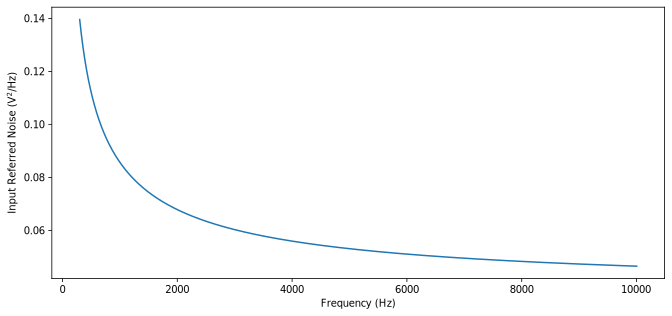

In [8]:
# Specify the path to your .raw file
filepath = '../../netlist/tb_inv_sky130_a_noise_spectrum_pl.raw'

# Load the LTSpice file
lt = ltspice.Ltspice(filepath)
lt.parse()

inoise = lt.get_data('inoise_spectrum')*1e6  # Convert to uV
frequency = lt.get_data('frequency')

# Create a larger figure
plt.figure(figsize=(11, 5))

# Plotting the data
plt.plot(frequency, inoise)

# Adding axis labels
plt.xlabel('Frequency (Hz)')
plt.ylabel('Input Referred Noise (V$^2$/Hz)')

# Displaying the plot
plt.savefig('inoise_pl.pdf')
plt.show()




## DC analysis

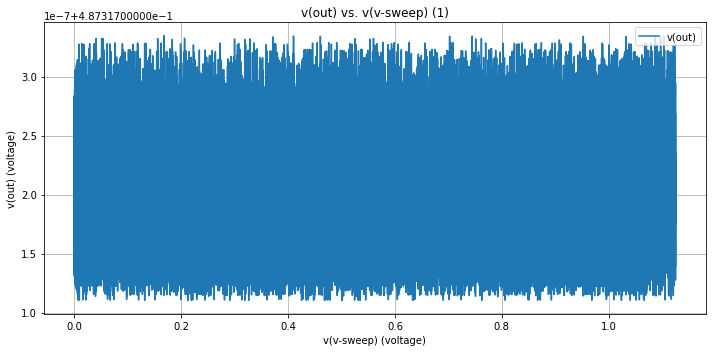

v(out) equals v(v-sweep) at v = 0.48731 V
v(out) equals v(v-sweep) at v = 0.48732 V
v(out) equals v(v-sweep) at v = 0.48733 V


In [ ]:

filepath = '../../netlist/tb_inv_sky130_a_DC_pl.raw'
arrs, plots = rawread(filepath)
plot_dynamic(arrs, plots, x_scale='linear', y_scale='linear', is_data_in_dB=False, mark_cutoff=False)
for data, meta in zip(arrs, plots):
    x_data = data['v(v-sweep)']  # Assuming this is your x-axis data name
    y_data = data['v(out)']  # Assuming this is your y-axis data name
        
    # Find indices where v(out) approximately equals v(v-sweep)
    # Using np.isclose to handle floating-point precision issues
    indices = np.where(np.isclose(x_data, y_data, atol=1e-5))[0]
        
    if indices.size > 0:
        for index in indices:
            print(f"v(out) equals v(v-sweep) at v = {x_data[index]:.5f} V")
    else:
        print("No points found where v(out) equals v(v-sweep)")
    

## AC analysis

/Users/miguelcorrea/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


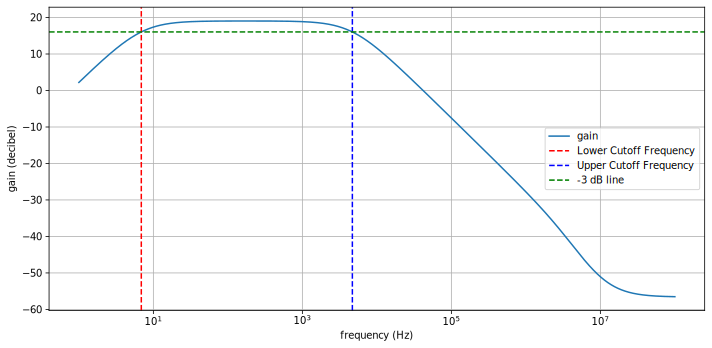

The peak gain is: 19.056297568081686 dB
The lower cutoff frequency is: 6.886522963442455 Hz
The upper cutoff frequency is: 4688.133821451729 Hz


In [13]:
arrs, plots = rawread('../../netlist/tb_inv_sky130_a_AC_pl.raw')
peak_gain, lower_cutoff_frequency_sim, upper_cutoff_frequency_sim = plot_dynamic(arrs, plots, x_scale='log', y_scale='linear', is_data_in_dB=True, mark_cutoff=True, num_plots=1)
print(f"The peak gain is: {peak_gain} dB")
print(f"The lower cutoff frequency is: {lower_cutoff_frequency_sim} Hz")
print(f"The upper cutoff frequency is: {upper_cutoff_frequency_sim} Hz")

## Power (and trans) simulation

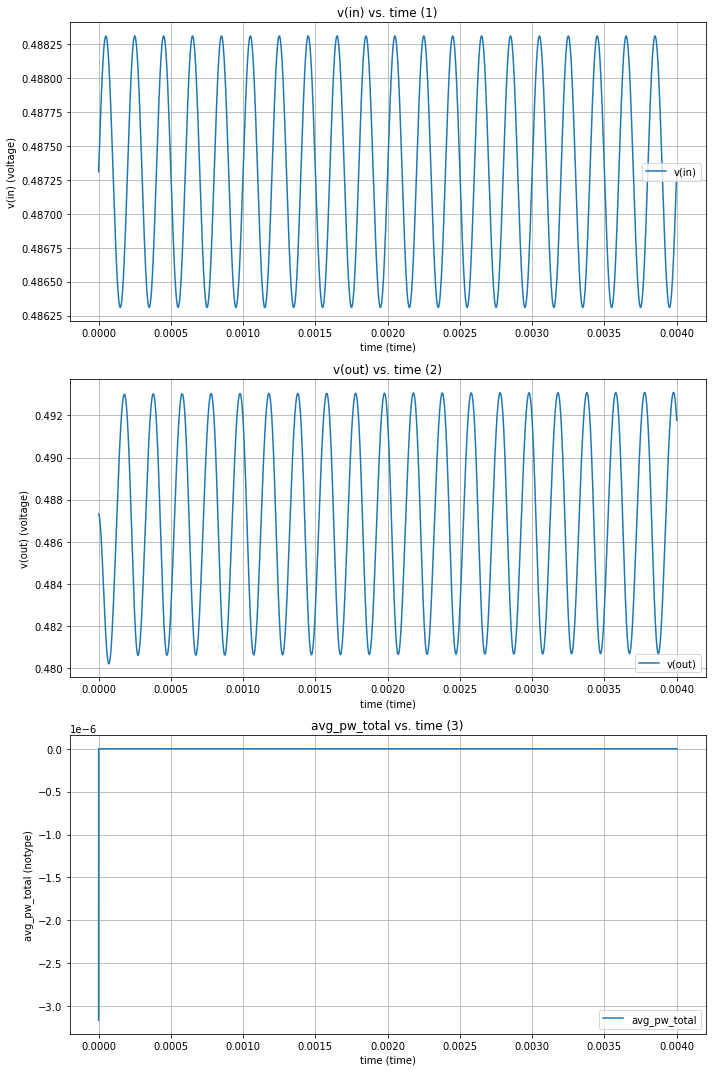

In [ ]:
filepath = '../../netlist/tb_inv_sky130_a_tran_pl.raw'  # Update to your .raw file path

arrs, plots = rawread(filepath)
plot_dynamic(arrs, plots, x_scale='linear', y_scale='linear', is_data_in_dB=False, mark_cutoff=False, num_plots=6)

In [ ]:
filepath = '../../netlist/tb_inv_sky130_a_tran_pl.raw'  # Update to your .raw file path

# Load the LTSpice raw file
lt = ltspice.Ltspice(filepath)
lt.parse()
avg_pw_total = lt.get_data('avg_pw_total')[0]*1e6  # Convert to uW
print(f"The average power is: {abs(avg_pw_total)} uW")

[Warning] Variable data type is detected as double precision.
The average power is: 3.16325 uW


#### Results of simulation summary

In [ ]:
# Here I will store my real simulation outputs
# order: gain (in dB), cut-off, noise, power
results_sim = np.array([peak_gain.real, lower_cutoff_frequency_sim.real,upper_cutoff_frequency_sim.real, inoise.real, abs(avg_pw_total.real)])
print("The results of the simulation are: ")
print(f"Gain = {results_sim[0]} dB")
print(f"Lower cut-off = {results_sim[1]} Hz")
print(f"Upper cut-off = {results_sim[2]/1e3} kHz")
print(f"Noise = {results_sim[3]} uV")
print(f"Power = {results_sim[4]} uW")

The results of the simulation are: 
Gain = 19.056297568081686 dB
Lower cut-off = 6.886522963442455 Hz
Upper cut-off = 4.688133821451729 kHz
Noise = 5.997455972020203 uV
Power = 3.16325 uW
